# <center> COMP 562 : Inroduction to Machine Learning<font color='red'> -- Assigment 1 Solution</font>  </center> 
## <center> Sentiment Analysis on IMDB Movie Reviews Using Logistic Regression </center>

In [1]:
import numpy as np

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

In [111]:
#download data
import time
import urllib
import os.path
import sys
versionName = sys.version_info
if versionName[0] == 2:
    import urllib as U
elif versionName[0] == 3:
    import urllib.request as U
start = time.time()
print("Should take at most 30 seconds")
if not os.path.isfile('train_data.pgz'):
    U.urlretrieve("https://cs.unc.edu/~ycharn/comp562/hw1/train_data.pgz", "train_data.pgz")
if not os.path.isfile('test_data.pgz'):
    U.urlretrieve("https://cs.unc.edu/~ycharn/comp562/hw1/test_data.pgz", "test_data.pgz")
if not os.path.isfile('vocab_list.pgz'):
    U.urlretrieve( "https://cs.unc.edu/~ycharn/comp562/hw1/vocab_list.pgz", "vocab_list.pgz" );
end = time.time()
print("Time elapsed (seconds):", end-start)

Should take at most 30 seconds
('Time elapsed (seconds):', 7.4720001220703125)


In [112]:
#load data
try:
    import cPickle as pickle
    kwargs = {}
except:
    import _pickle as pickle
    kwargs = {'encoding':'bytes'}
    
import gzip
import numpy as np
start = time.time()
print("Should take about 15 seconds")
train_data, train_label = pickle.load( gzip.open( "train_data.pgz", "rb" ), **kwargs )
train_label = np.asarray(train_label)
test_data = pickle.load( gzip.open( "test_data.pgz", "rb" ),**kwargs )
vocab_list = pickle.load( gzip.open( "vocab_list.pgz", "rb" ),**kwargs )
end = time.time()
print("Time elapsed (seconds):", end-start)

Should take about 15 seconds
('Time elapsed (seconds):', 18.56599998474121)


In [113]:
#Consider using small set of the data
trainData = train_data[:10000, :]
validData = train_data[10000:15000, :]
trainLabel = train_label[:10000]
validLabel = train_label[10000:15000]
testData = test_data[:10000, :]


In [114]:
import numpy as np
#We help you do the concatenate, so the first feature becomes the  bias term
train_data_pad = np.concatenate( ( np.ones((trainData.shape[0], 1)), trainData ), axis = 1 )
test_data_pad = np.concatenate( ( np.ones((testData.shape[0], 1)), testData ), axis = 1 )
valid_data_pad = np.concatenate( ( np.ones((validData.shape[0], 1)), validData ), axis = 1 )

## To-do: 
1. Given the data $D = {(\mathbf{x}_i, y_i)} $, write down the likelihood function ($L(\mathbf{w})$) of logistic regression. **[1 pt]**
2. Take $\log$ of the likelihood function in (1), write down the log likelihood function. Hint: $\log$ will not cancel $\exp$. **[1 pt]**
3. Add  ridge penalty in the log likelihood function (Let the weight of ridge penalty be $\alpha$). Hint: Do not include $w_0$ in the ridge term. **[1 pt]**
4. Write a function to compute regularized log likelihood **[1 pt]**

1. $ L(\mathbf{w}) = \prod_{i=1}^N p(y_i|\mathbf{x}_i, \mathbf{w}, b) = \prod_{i=1}^N\frac{1}{1+exp\{-y_i(\mathbf{w} \cdot \mathbf{x}_i + b)\}} $
2. $ LL(\mathbf{w}) = -\sum_i \log\{1+exp\{-y_i(\mathbf{w} \cdot \mathbf{x}_i + b)\} $
3. $ PLL(\mathbf{w}) = -\sum_i \log\{1+exp\{-y_i(\mathbf{w} \cdot \mathbf{x}_i + b)\ - \frac{\alpha}{2}\sum_{j=1}^{p} w_j^2 $

In [115]:
import numpy as np
def loglikelihood(w, X, y, alpha): 
    #compute loglikelihood for current w, b, given the data X, y
    #w is a vector, b is a scalr, X is a n*p matrix and y is a vector.
    tmp = 1. + np.exp( -y*(np.dot(X,w)))
    return -np.sum( np.log(tmp) ) - (alpha/2.)*np.sum( w[1:]**2. )

In [116]:
# testing
np.random.seed(1)
X = np.random.randn(2,3)
y = np.array([1,-1])
w = np.ones(3)
w[[1]] = -1;
loglikelihood(w, X, y, 1)


-1.1808712118395306

In [117]:
#the values printed in this cell should be the same as the value printed in the previous cell.
print( -np.log(1+np.exp(-1*(X[0,0]-X[0,1]+X[0,2]))) - np.log(1+np.exp(1*(X[1,0]-X[1,1]+X[1,2]))) -1/2.*np.sum(w[1:]**2) )

-1.18087121184


<a href="#top_of_steps">top</a>

# Compute derivative of logistic regression.

In order to optimize the function, we want to take the derivative of the function, and update $\mathbf{w}$ according to the direction of the gradient.

## To-do:
1. Write down the derivative of the **penalized log likelihood function** for each $ w_j $. Hint: Remember that bias term is $w_0$ and treat it separately from the rest of $w_j$, $j\in\{1,...,p\}$ **[1 pt]**
2. Write down the gradient of log likelihood function. Hint: You can express this in terms of probabilities. **[1 pt]**
3. Update the loglikelihood function to return both the loglikelihood and the gradient. **[1 pt]**

1. 
$ \frac{\partial PLL(\mathbf{w})}{ \partial w_0} = \sum_i \frac{\exp\{-y_i(\mathbf{w'} \cdot \mathbf{x'}_i)}{1+\exp\{-y_i(\mathbf{w'} \cdot \mathbf{x'}_i)}y_i$ <br \>
$ \frac{\partial PLL(\mathbf{w})}{ \partial w_j} = \sum_i  \frac{\exp\{-y_i(\mathbf{w'} \cdot \mathbf{x'}_i)}{1+\exp\{-y_i(\mathbf{w'} \cdot \mathbf{x'}_i)}y_ix_{i,j} - \alpha x_{i,j}, j>0$ 
<br \>
2. 
$ \nabla PLL(\mathbf{w}) = \sum_i (1 - p(y_i|\mathbf{x'}_i,\mathbf{w}')) y_i\begin{bmatrix}  1\\x_{i,1} \\ \vdots \\ x_{i,p} \end{bmatrix} - \begin{bmatrix}  0 \\ \alpha w_1  \\ \vdots \\ \alpha w_p \end{bmatrix} $

In [118]:
import numpy as np
def loglikelihood(w, X, y, alpha): 
    #compute loglikelihood for current w given the data X, y
    #w is a (p+1) vector which includes b as w[0], 
    #X is a n*(p+1) matrix with the first column composed of 1s
    #y is a (n*1)vector.
    tmp = 1. + np.exp( -y*np.dot(X,w) )
    prob = 1./tmp
    X = X.transpose() #X becomes a p*n matrix so the gradVal can be compute straight-forwardly.
    gradVal = np.sum(X*((1 - prob)*y),axis=1)
    penalty = alpha/2.*np.sum(w[1:]**2)
    gradPenalty = -alpha*w
    gradPenalty[0] = 0;
    return -np.sum( np.log( tmp ) ) - penalty, gradVal + gradPenalty

In [119]:

# %load grad_check.py
def grad_check(f,xy0,delta=1e-6,tolerance=1e-7):
    f0,g0 = f(xy0)
    p = len(xy0)
    finite_diff = np.zeros(p)
    gradient_correct = True
    for i in range(p):
        xy1 = np.copy(xy0)
        xy2 = np.copy(xy0)
        xy1[i] = xy1[i] - 0.5*delta
        xy2[i] = xy2[i] + 0.5*delta
        f1,_ = f(xy1)
        f2,_ = f(xy2)
        finite_diff = (f2 - f1)/(delta)
        if (abs(finite_diff - g0[i])>tolerance):
            print("Broken partial",i," Finite Diff: ",finite_diff," Partial: ",g0[i])
            gradient_correct = False
    return gradient_correct

In [120]:
w_init = np.random.randn( train_data_pad.shape[1] )*0.001
w_init[0] = 0

In [121]:
g = lambda xy0: loglikelihood(xy0, X=train_data_pad[:,:15], y=trainLabel, alpha=1)
grad_check( g, w_init[:15], delta=1e-6, tolerance=1e-5 )

True

In [123]:
import matplotlib.pyplot as plt
%matplotlib inline
# %load gradient_ascent
def gradient_ascent(f,x,init_step,iterations):  
    f_val,grad = f(x)                           # compute function value and gradient 
    f_vals = [f_val]
    for it in range(iterations):                # iterate for a fixed number of iterations
        #print 'iteration %d' % it
        done = False                            # initial condition for done
        line_search_it = 0                      # how many times we tried to shrink the step
        step = init_step                        # reset step size to the initial size
        while not done and line_search_it<100:  # are we done yet?
            new_x = x + step*grad               # take a step along the gradient
            new_f_val,new_grad = f(new_x)       # evaluate function value and gradient
            if new_f_val<f_val:                 # did we go too far?
                step = step*0.95                # if so, shrink the step-size
                line_search_it += 1             # how many times did we shrank the step
            else:
                done = True                     # better than the last x, so we move on
        
        if not done:                            # did not find right step size
            print("Line Search failed.")
        else:
            f_val = new_f_val                   # ah, we are ok, accept the new x
            x = new_x
            grad = new_grad
            f_vals.append(f_val)
        plt.plot(f_vals)
    plt.xlabel('Iterations')
    plt.ylabel('Function value')
    return f_val, x

In [124]:
np.random.seed(12345)
w_init = np.random.randn( train_data_pad.shape[1] )*0.001
w_init[0] = 0

## To-do:
* Try different init_step (1e-4, 1e-5, 1e-6) using the following code, report the final regularized log-likelihood values. **[1 pt]**

In [125]:
def optimizeFn( init_step, iterations, alpha, w):
    g = lambda xy0: loglikelihood(xy0, train_data_pad, trainLabel, alpha)
    f_val, update_w = gradient_ascent( g, w, init_step, iterations )
    return f_val, update_w

Init_step: 0.0001 final log-likelihood = -2602.17036787
Init_step: 1e-05 final log-likelihood = -3033.03824892
Init_step: 1e-06 final log-likelihood = -4707.15530113


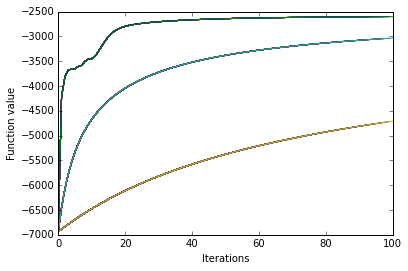

In [132]:
for init_step in [1e-4,1e-5,1e-6]:
    start = time.time()
    f_val, update_w=optimizeFn( init_step = init_step, iterations=100, alpha=0, w = w_init) #set init_step to 1e-4, 1e-5, 1e-6
    end = time.time()
    print('Init_step: {} final log-likelihood = {}'.format(init_step,f_val))

Final regularized log-likelihood values for (1e-4, 1e-5, 1e-6) are: ...

## To-do:
1. Implement the prediction function. It should take as inputs feature weights and feature matrix. It should return vector of labels. **[1 pt]**
2. Try different alpha (1000, 2000, 3000), and report which alpha produces the model that has the best accuracy on the validation set **[1 pt]**
2. **[optional]** Report one sample that is classified wrong with high probabilites (> 90%). **[1 pt]**
3. **[optional]** Report the words (entries in vocab_list associated with that feature) that cause the sample reported in (2) classify wrong. Note that weight w[i] correponds to word vocab_list[i-1], because we included bias term in w.**[1 pt]**

In [128]:
def prediction(w, validData ):
    prob = 1./(1+np.exp( -np.dot(validData, w) ));
    res = np.zeros(validData.shape[0])
    res[prob>=0.5] = 1
    res[prob<0.5] = -1
    return res

alpha=1000 accuracy on the validation set 84.52%
alpha=2000 accuracy on the validation set 84.60%
alpha=3000 accuracy on the validation set 84.74%
Best alpha: 3000 accuracy is 84.74


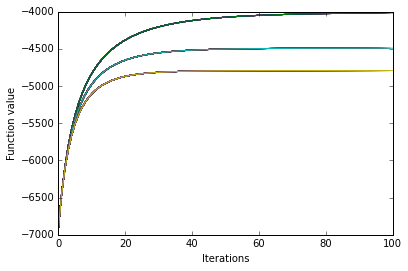

In [134]:
#see the accuracy on the validation set
#when init_step=1e-5, the model has the best accuracy in the validation set
best_accuracy = 0
for alpha in [1000,2000,3000]:
    f_val, update_w=optimizeFn( init_step = 1e-5, iterations=100, alpha=alpha, w=w_init) #try different alphas [1000, 2000, 3000]
    pred = prediction(update_w, valid_data_pad)
    accuracy = 100.*np.mean(pred==validLabel)
    print( 'alpha={} accuracy on the validation set {:.2f}%'.format( alpha, accuracy ))
    if accuracy>best_accuracy:
        best_alpha = alpha
        best_accuracy = accuracy

print("Best alpha: {} accuracy is {}".format(best_alpha, best_accuracy))

In [135]:
wrong_idx = np.nonzero( validLabel != pred )[0] #use this command to get the samples that are predicted wrong

In [136]:
#implement the function to compute probability
def computeProb(w, validData ):
    prob = 1./(1+np.exp( -np.dot(validData, w) ))
    return prob

In [140]:
#get the samples that are classified wrong and with probabilites > 0.9
probs = computeProb(update_w, valid_data_pad)
wrong_idx_high = [i for i in wrong_idx if probs[i]>0.9 or probs[i]<0.1]
sampleIdx = [wrong_idx_high[0]]
print

Sample index is [95]


In [210]:
#Use this function to get the most important words for each sample index
#This function returns a list of top 10 words that influence the prediction.
def getMostImportantFeatures( sampleIdx, validData, update_w, vocab_list ):
    importantList = []
    intensity = validData[sampleIdx,:]*update_w
    tmp = np.argsort( np.abs(intensity[0,:]) )[::-1]
    for j in np.arange(10):
        importantList.append(vocab_list[tmp[j]-1])
    return importantList

In [211]:
importantList = getMostImportantFeatures( sampleIdx, valid_data_pad, update_w, vocab_list) #use the sample index got from the previous result
print importantList


[u'please', u'atmosphere', u'dull', u'poor', u'excellent', u'bad', u'point', u'job', u'make', u'silly']


In [212]:
#load file ids
if not os.path.isfile('train_id.pgz'):
    U.urlretrieve( "https://cs.unc.edu/~ycharn/comp562/hw1/train_id.pgz", "train_id.pgz" );
train_id = pickle.load( gzip.open( "train_id.pgz", "rb" ) )
valid_id = train_id[10000:15000]

In [213]:
fileName = valid_id[sampleIdx[0]]
fileUrl = "https://cs.unc.edu/~ycharn/comp562/hw1/reviews/" + fileName + '.txt'

In [215]:
U.urlretrieve(fileUrl, fileName)
U.urlretrieve(fileUrl, fileName)
with open(fileName, 'r') as f:
    print(f.read())

These are excerpts from a nine-page "Memo to Mr. Cohn from Mr. Welles", written after Orson had seen studio mogul Harry Cohn's edited version of the picture (he took an hour out): <br /><br />"...The preview title music was written by a first rate composer, George Antheil. Although not written for our picture at all, this temporary title music had an atmosphere of darkness and menace combined with something lush and romantic which made it acceptable...The only musical idea which seems to have occurred to this present composer (Heinz Roemheld) is the rather weary one of using a popular song--the "theme"--in as many arrangements as possible. Throughout we have musical references to "Please Don't Kiss Me" for almost every bridge and also for a great deal of the background material. The tune is pleasing, it may do very well on the Hit Parade--but Lady from Shanghai is not a musical comedy...Mr. Roemheld is an ardent devotee of an old-fashioned type of scoring now referred to in our busines

<a href="#top_of_steps">top</a>